Created Fall 2023
# <mark style="background-color: #7bb8c0"> <font color ='#ffebad'> Build Idealized Model SAL, Heat, PmE, NET_SOL. </font></mark>

# <mark style="background-color: #543786"> <font color ='#a7b5f3'> Table of Contents. </font></mark>
1. **[Background](#1)**
2. **[Make Files](#2)**

# <mark style="background-color: #feb737"> <font color ='#543786'> 1. Background. </font></mark>
<a name=1></a>

These are zonally uniform forcing files. Since `BUOY_CONFIG= 'MESO'` in `MOM_INPUT`, forcing files (SST, taux, tauy, Heat, PmE, NET_SOL) are required to run the model. They are first called in [`MESO_surface_forcing.F90`](https://github.com/kailauyeda/single_basin_amoc_tropics/blob/main/MOM6_changes/MESO_surface_forcing.F90) file. 

`SAL` is a "fake file" that will be overriden by calculations in `MESO_surface_forcing.F90`, so it is a duplicate of `SST` with altered an variable name. `

`PmE` must be full of zeros since we do not want precipitation in the experiment. Same for `Heat` (sensible heat flux) and `NET_SOL` (shortwave flux).

The non-uniform forcing files that we want used in the simulations are built in [this notebook](https://github.com/kailauyeda/single_basin_amoc_tropics/blob/main/6-21_build_INPUT/bathymetry_wind_SST_build.ipynb).

Full MOM6 forcing files for the single basin experiment are found in [`6-12_INPUT_figures`](https://github.com/kailauyeda/single_basin_amoc_tropics/blob/main/6-21_build_INPUT/6-12_INPUT_figures.ipynb).

**NOTE: In `MESO_surface_forcing.F90`, we set fluxes_vprec(rho_restore, flux_const, salt) =0.**

|variable name | called in `MESO_surface_forcing.F90`| full name | actually contains|why|
|:--| :--| :--|:--|:--|
|`NET_SOL` | `solar_file` |short wave heat flux| zeros|SST set by relaxation, not flux|
|`Heat`| `heating_file`| longwave \& sensible heat flux| zeros|SST set by relaxation, not flux |
|`SAL`| `salinityrestore_file` | salinity| match SST| only used in `fluxes%vprec`|
|`PmE` |`PmE_file` | precipitation - evaporation| zeros| we don't want any preciptiation; used in `fluxes%lprec`|

In [1]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.interpolate
import xarray as xr
import netCDF4 as nc4
import cmocean.cm as cmo
import cmocean

# <mark style="background-color: #7bb8c0"> <font color ='#ffebad'> 2. Create Forcing files for SAL, Heat, PmE, NET_SOL. </font></mark>
<a name=2></a>
`SST` will be the standard file to set all values to. 

In [2]:
# open SST file 
file_path = '/vortex1/jupyter-kuyeda/t_m_p_wind/INPUT/'
SST = xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/11-27_NaN_SST.nc')
# SST.SST.plot()

## <font color='7bb8c0'> Use `SST` file to make new uniform forcing files. </font>

In [3]:
string = ["SAL","Heat","PmE","NET_SOL"]

# copy the SST file and rename the variables appropriately
for i in range(0,4):
    renamed_var = SST.rename({"SST":string[i]})
    renamed_var.to_netcdf('/vortex1/jupyter-kuyeda/files_to_delete/6-17_demo_'+string[i]+'_not_real.nc')

In [4]:
# open topography to mask basin
topo=xr.open_dataset(file_path+'topo_file_test1.nc')
topo

<xarray.Dataset>
Dimensions:  (xh: 80, yh: 140, xq: 81, yq: 141)
Coordinates:
  * xh       (xh) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 75.5 76.5 77.5 78.5 79.5
  * yh       (yh) float32 -69.5 -68.5 -67.5 -66.5 -65.5 ... 66.5 67.5 68.5 69.5
  * xq       (xq) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 76.0 77.0 78.0 79.0 80.0
  * yq       (yq) float32 -70.0 -69.0 -68.0 -67.0 -66.0 ... 67.0 68.0 69.0 70.0
Data variables:
    z        (yh, xh) float32 ...
Attributes:
    title:     Neverworld2 test bathymetry
    subtitle:  subtitle

## <font color='7bb8c0'> Add NaNs and zeros. </font>
Because the basin has topography at the bottom and around the edges, there cannot be values for variables there. Some variables require NaNs there. Some variables require zeros there. Made files for both to check. 
Ultimately:

| Variable | Account for topography with|
|:--| :-- |
| `SST` | NaNs |
|`SAL` | NaNs |
|`Heat`| zeros| 
|`NET_SOL`| zeros|
|`PmE` | zeros|


In [5]:
string = ["SAL","Heat","PmE","NET_SOL"]
ds_string = ["SAL","Heat","PmE","NET_SOL"]

# open the duplicate SST files that now represent the new variables
for i in range(0,4):
    ds_string[i] = xr.open_dataset('/vortex1/jupyter-kuyeda/files_to_delete/6-17_demo_'+string[i]+'_not_real.nc')

for i in range(0,4):
    # get where coast is 
    nan = (ds_string[i][string[i]]).where(topo.z !=0)
    # nans
    nan.to_netcdf(file_path + '6-17_NaN_'+string[i]+'.nc')
    nan_file = xr.open_dataset(file_path + '6-17_NaN_'+ string[i]+'.nc')
    # zeros
    zero = nan_file.fillna(0)
    zero.to_netcdf(file_path + '6-17_zero_' + string[i] + '.nc')
    

In [6]:
# for temperature
nan_temp = SST.where(topo.z !=0)
nan_temp.to_netcdf(file_path + '6-17_NaN_SST.nc')

# zero_temp = nan_temp.fillna(0)
# zero_temp.to_netcdf(file_path + '11-27_zero_SST.nc')

## <font color='7bb8c0'> Make PmE, NET_SOL, Heat zero everywhere. </font>

In [11]:
open_zero = xr.open_dataset(file_path + '6-17_zero_PmE.nc')
recalc = (open_zero.PmE-open_zero.PmE) / 10**4
recalc.to_netcdf(file_path + '6-17_PmE_all_zeros.nc')


open_zero_NET_SOL = xr.open_dataset(file_path + '6-17_zero_NET_SOL.nc')
recalc_NET_SOL = (open_zero_NET_SOL.NET_SOL - open_zero_NET_SOL.NET_SOL)
recalc_NET_SOL.to_dataset(name='NET_SOL').to_netcdf(file_path + '7-17_NET_SOL_all_zeros3.nc')

open_zero_Heat = xr.open_dataset(file_path + '6-17_zero_Heat.nc')
recalc_Heat = (open_zero_Heat.Heat - open_zero_Heat.Heat)
recalc_Heat.to_dataset(name='Heat').to_netcdf(file_path + '7-17_Heat_all_zeros3.nc')

In [17]:
all_zeros_PmE = xr.open_dataset(file_path + '6-17_zero_PmE.nc')
all_zeros_NET_SOL = xr.open_dataset(file_path + '7-17_NET_SOL_all_zeros3.nc')
all_zeros_Heat = xr.open_dataset(file_path + '7-17_Heat_all_zeros3.nc')

Text(0, 0.5, 'Latitude ($^{\\circ}$N)')

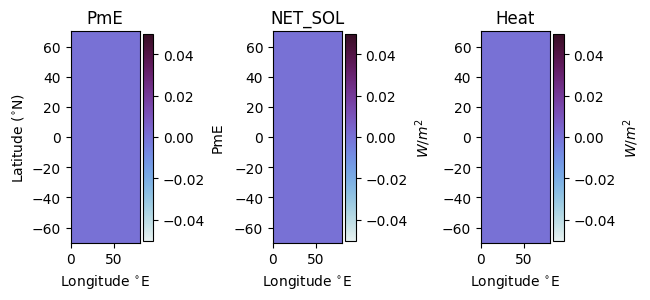

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True)

recalc.plot(cmap=cmocean.cm.dense,ax=ax[0],cbar_kwargs={'label':'PmE'})
ax[0].set_title('PmE')

all_zeros_NET_SOL.NET_SOL.plot(cmap=cmocean.cm.dense,ax=ax[1],cbar_kwargs={'label':'$W/m^2$'})
ax[1].set_title('NET_SOL')

all_zeros_Heat.Heat.plot(cmap=cmocean.cm.dense,ax=ax[2],cbar_kwargs={'label':'$W/m^2$'})
ax[2].set_title('Heat')

for i in range(0,3):
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Longitude $^{\circ}$E')
    ax[i].set_aspect(140/80)

ax[0].set_ylabel('Latitude ($^{\circ}$N)')